In [1]:
#https://github.com/etown/dl1/blob/master/UrbanSoundClassification.ipynb

import os
import glob
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import librosa.display
import numpy as np
from fastai import *
from fastai.vision import *
from fastai.vision.data import ImageDataLoaders
from fastai.vision.all import Normalize, Resize, imagenet_stats, cnn_learner, error_rate
from tqdm import tqdm

labels  = ['air_conditioner','car_horn','children_playing',
           'dog_bark','drilling','engine_idling','gun_shot','jackhammer','siren','street_music']

  0%|          | 1/873 [00:00<02:27,  5.90it/s]

Processing fold 1 of 10


 96%|█████████▌| 840/873 [1:14:13<02:54,  5.30s/it]


KeyboardInterrupt: 

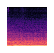

In [8]:
data_path = Path('UrbanSound8K/data/') 
spectrogram_path = Path('UrbanSound8K/spectrogram/')
audio_path = Path('UrbanSound8K/audio/')

if (not os.path.isdir(data_path)):
    os.mkdir(data_path)

if (not os.path.isdir(spectrogram_path)):
    os.mkdir(spectrogram_path)

def create_fold_spectrograms(fold): 
    if (os.path.isdir(spectrogram_path/fold)):
        print(f"Directory {spectrogram_path/fold} already exists, skipping fold {fold}")
        return
    os.mkdir(spectrogram_path/fold)

    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    for audio_file in tqdm(list(Path(audio_path/f'fold{fold}').glob('*.wav'))):
        samples, sample_rate = librosa.load(str(audio_file))
        filename = spectrogram_path/fold/Path(audio_file).name.replace('.wav','.png')
        S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close('all')

def create_fold_directory(fold):
    if (os.path.isdir(data_path/fold)):
        print(f"Directory {data_path/fold}        already exists, skipping fold {fold}")
        return
    png_files = list(Path(spectrogram_path/fold).glob('*.png'))
    os.mkdir(data_path/fold)
    os.mkdir(data_path/fold/'train')
    os.mkdir(data_path/fold/'valid')
    for label in labels:
        os.mkdir(data_path/fold/'train'/label)
        os.mkdir(data_path/fold/'valid'/label)
     
    for file in png_files:
        label = file.as_posix().split('-')[1]
        shutil.copyfile(file, data_path/fold/'valid'/labels[int(label)]/file.name)   
    for i in range(1, 11):       
        if str(i) == fold:
            continue
        png_files = list(Path(spectrogram_path/str(i)).glob('*.png'))
        for file in png_files:
            label = file.as_posix().split('-')[1]
            shutil.copyfile(file, data_path/fold/'train'/labels[int(label)]/file.name)

for i in range(1, 11):
    print(f'Processing fold {i} of 10')
    create_fold_spectrograms(str(i))

for i in range(1, 11):
    create_fold_directory(str(i))


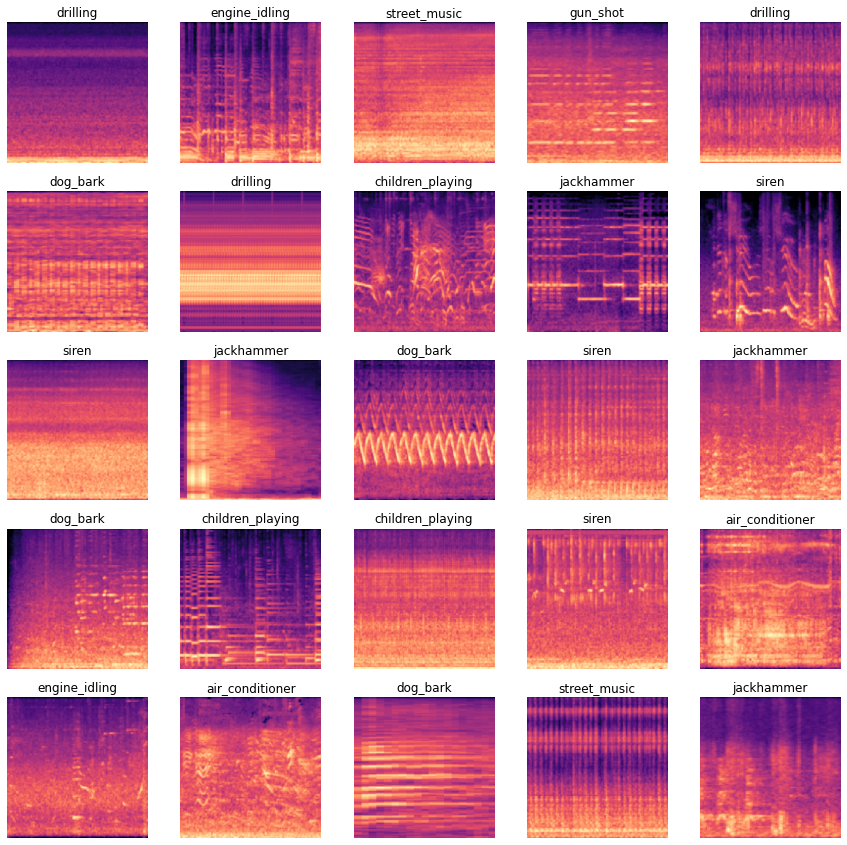

In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

data_directory = Path('UrbanSound8K/data')
# don't use any transformations because it doesn't make sense in the case of a spectrogram
# i.e. flipping a spectrogram changes the meaning
# data = ImageDataBunch.from_folder(data_directory/'1', ds_tfms=[], size=224)
# data = ImageDataLoaders.from_folder(data_directory/'1', item_tfms=[Resize(224), Normalize.from_stats(*imagenet_stats)])
data = ImageDataLoaders.from_folder(data_directory/'1', 
                                    item_tfms=Resize(224), 
                                    batch_tfms=Normalize.from_stats(*imagenet_stats))
data.show_batch(max_n=25)

In [36]:
def process_fold(fold):
    data_directory = Path('UrbanSound8K/data')
    data = ImageDataLoaders.from_folder(data_directory/fold, 
                                    item_tfms=Resize(224), 
                                    batch_tfms=Normalize.from_stats(*imagenet_stats),
                                    num_workers=0)
    learn = cnn_learner(data, models.resnet34, metrics=error_rate)
    print(type(learn))
    learn.fit_one_cycle(3)
    learn.unfreeze()
    learn.fit_one_cycle(1)
    learn.fit_one_cycle(3, lr_max=slice(1e-6,1e-4))

In [37]:
process_fold('1')

<class 'fastai.learner.Learner'>


epoch,train_loss,valid_loss,error_rate,time
0,1.466415,0.799638,0.260023,00:55
1,0.731204,0.723619,0.223368,00:55
2,0.496718,0.729750,0.234822,00:55


epoch,train_loss,valid_loss,error_rate,time
0,0.494464,0.721542,0.222222,01:05


epoch,train_loss,valid_loss,error_rate,time
0,0.240834,0.726040,0.215349,01:05
1,0.199870,0.792964,0.227950,01:06
2,0.185921,0.816924,0.218786,01:05


In [38]:
process_fold('2')

<class 'fastai.learner.Learner'>


epoch,train_loss,valid_loss,error_rate,time
0,1.437411,1.207348,0.352477,01:34
1,0.761671,1.181355,0.298423,00:55
2,0.507261,1.106144,0.283784,00:55


epoch,train_loss,valid_loss,error_rate,time
0,0.523863,0.834592,0.282658,01:05


epoch,train_loss,valid_loss,error_rate,time
0,0.260937,0.875550,0.278153,01:05
1,0.226260,0.927246,0.269144,01:05
2,0.184967,0.904420,0.266892,01:05


In [39]:
process_fold('3')

<class 'fastai.learner.Learner'>


epoch,train_loss,valid_loss,error_rate,time
0,1.460968,0.971900,0.349189,01:34
1,0.729484,0.799124,0.281081,00:56
2,0.474641,0.792644,0.276757,00:55


epoch,train_loss,valid_loss,error_rate,time
0,0.556544,0.924009,0.256216,01:05


epoch,train_loss,valid_loss,error_rate,time
0,0.270237,0.892606,0.262703,01:05
1,0.229138,0.887657,0.271351,01:05
2,0.203102,0.897378,0.271351,01:05


In [40]:
process_fold('4')

<class 'fastai.learner.Learner'>


epoch,train_loss,valid_loss,error_rate,time
0,1.454038,1.122032,0.361616,01:35
1,0.751227,0.997711,0.324242,00:55
2,0.486612,0.964999,0.319192,00:57


epoch,train_loss,valid_loss,error_rate,time
0,0.535056,0.737970,0.227273,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.259612,0.732718,0.222222,01:08
1,0.217156,0.729682,0.223232,01:07
2,0.197174,0.732941,0.241414,01:08


In [41]:
process_fold('5')

<class 'fastai.learner.Learner'>


epoch,train_loss,valid_loss,error_rate,time
0,1.449306,0.819291,0.285256,01:41
1,0.738553,0.683220,0.237179,00:57
2,0.502364,0.641647,0.216880,00:56


epoch,train_loss,valid_loss,error_rate,time
0,0.528194,0.366056,0.113248,01:06


epoch,train_loss,valid_loss,error_rate,time
0,0.236828,0.333066,0.098291,01:07
1,0.203451,0.323586,0.097222,01:07
2,0.186544,0.321064,0.096154,01:06


In [42]:
process_fold('6')

<class 'fastai.learner.Learner'>


epoch,train_loss,valid_loss,error_rate,time
0,1.385393,1.403167,0.381531,01:38
1,0.717069,1.350200,0.321993,00:57
2,0.470201,1.304630,0.297691,00:56


epoch,train_loss,valid_loss,error_rate,time
0,0.543875,0.905074,0.216282,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.246964,0.857437,0.202916,01:07
1,0.194887,0.848303,0.185905,01:07
2,0.200282,0.853857,0.193196,01:07


In [43]:
process_fold('7')

<class 'fastai.learner.Learner'>


epoch,train_loss,valid_loss,error_rate,time
0,1.384005,1.255941,0.349642,01:39
1,0.691600,1.043375,0.301909,00:56
2,0.471346,1.056593,0.299523,00:56


epoch,train_loss,valid_loss,error_rate,time
0,0.536857,0.629860,0.205251,01:06


epoch,train_loss,valid_loss,error_rate,time
0,0.255028,0.624218,0.200477,01:06
1,0.205417,0.633687,0.190931,01:07
2,0.197883,0.657366,0.195704,01:07


In [44]:
process_fold('8')

<class 'fastai.learner.Learner'>


epoch,train_loss,valid_loss,error_rate,time
0,1.433455,1.270144,0.347395,01:38
1,0.711849,1.134914,0.308933,00:56
2,0.472916,1.135519,0.305211,00:56


epoch,train_loss,valid_loss,error_rate,time
0,0.563316,1.078201,0.246898,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.265104,1.078111,0.243176,01:07
1,0.216149,1.089699,0.244417,01:07
2,0.209651,1.076068,0.243176,01:07


In [45]:
process_fold('9')

<class 'fastai.learner.Learner'>


epoch,train_loss,valid_loss,error_rate,time
0,1.422779,0.885745,0.254902,01:38
1,0.740420,0.812376,0.209559,00:57
2,0.485034,0.821100,0.215686,00:56


epoch,train_loss,valid_loss,error_rate,time
0,0.522367,0.976887,0.202206,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.234702,0.991539,0.197304,01:07
1,0.205599,0.887968,0.182598,01:07
2,0.177760,0.909028,0.182598,01:07


In [46]:
process_fold('10')

<class 'fastai.learner.Learner'>


epoch,train_loss,valid_loss,error_rate,time
0,1.433894,1.000516,0.281959,01:41
1,0.708293,0.840582,0.232975,00:56
2,0.479383,0.849075,0.227001,00:57


epoch,train_loss,valid_loss,error_rate,time
0,0.493356,0.546804,0.149343,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.244696,0.525279,0.144564,01:07
1,0.193500,0.538261,0.139785,01:06
2,0.197543,0.558668,0.140980,01:06


In [52]:
error_rates = [0.219, 0.267, 0.271, 0.241, 0.096, 0.193, 0.196, 0.243, 0.183, 0.141]
accuracy = 1 - sum(error_rates) / 10
print(f"Overall accuracy is {accuracy * 100}%")

Overall accuracy is 79.5%
